In [1]:
### Add lines to import modules as needed
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential, Input, layers, Model
from keras.datasets import cifar10
from keras.optimizers import Adam, SGD
from keras.losses import categorical_crossentropy
from keras.utils import np_utils, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import load_img
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pp
from sklearn.utils import class_weight
import os
import cv2
from PIL import Image
# Don't worry about this, for some reason the SSL certificate isn't verifying for the Cifar10 dataset and this is the workaround
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
#define model
def mobilenet_v1():
    # Mobilenet parameters
    input_shape = [96,96,1] # resized to 96x96 per EEMBC requirement
    num_classes = 2 # person and non-person
    num_filters = 8 # normally 32, but running with alpha=.25 per EEMBC requirement

    inputs = Input(shape=input_shape)
    x = inputs # Keras model uses ZeroPadding2D()

    # 1st layer, pure conv
    # Keras 2.2 model has padding='valid' and disables bias
    x = layers.Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x) # Keras uses ReLU6 instead of pure ReLU

    # 2nd layer, depthwise separable conv
    # Filter size is always doubled before the pointwise conv
    # Keras uses ZeroPadding2D() and padding='valid'
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_filters = 2*num_filters
    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 3rd layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_filters = 2*num_filters
    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 4th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 5th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_filters = 2*num_filters
    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 6th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 7th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_filters = 2*num_filters
    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 8th-12th layers, identical depthwise separable convs
    # 8th
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 9th
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 10th
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 11th
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 12th
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 13th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_filters = 2*num_filters
    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 14th layer, depthwise separable conv
    x = layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D 
    x = layers.AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = layers.MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [3]:
#(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

img_size_x = 96
img_size_y = 96
batch_size = 16
data_dir = "C:\\Users\\lucas\\Documents\\GitHub\\Plasma_Dragon_Charged_Up_Code\\Machine_Learning\\training\\Plasma_Dragon_Cube_dataset\\"  #<- Change this

train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_size_x, img_size_y),
  batch_size=batch_size,
  color_mode='grayscale',
  label_mode='categorical')
val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_size_x, img_size_y),
  batch_size=batch_size,
  color_mode='grayscale',
  label_mode='categorical')
normalization_layer = tf.keras.layers.Rescaling(1./255)
num_classes = 2
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

mc = ModelCheckpoint(
    filepath = 'C:\\Users\\lucas\\Documents\\GitHub\\Plasma_Dragon_Charged_Up_Code\\Machine_Learning\\training\\best_model.h5', #<- Change this
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
es = EarlyStopping(monitor='loss', patience=3)

Found 1035 files belonging to 2 classes.
Using 828 files for training.
Found 1035 files belonging to 2 classes.
Using 207 files for validation.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
for data_batch, label_batch in train_ds:
    print('Data batch shape:', data_batch.shape)
    print('Label batch shape:', label_batch.shape)
    print(label_batch.numpy())
    break  # Only print the first batch

Data batch shape: (16, 96, 96, 1)
Label batch shape: (16, 2)
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [33]:
model = mobilenet_v1()
model.summary()
class_weights = {0: 1.89,1: 1.0}

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_84 (Conv2D)          (None, 48, 48, 8)         80        
                                                                 
 batch_normalization_162 (Ba  (None, 48, 48, 8)        32        
 tchNormalization)                                               
                                                                 
 activation_162 (Activation)  (None, 48, 48, 8)        0         
                                                                 
 depthwise_conv2d_78 (Depthw  (None, 48, 48, 8)        80        
 iseConv2D)                                                      
                                                                 
 batch_normalization_163 (Ba  (None, 48, 48, 8)        32  

In [34]:
model.compile(optimizer=Adam(learning_rate=0.01),loss=categorical_crossentropy,metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, batch_size=64, epochs=50,callbacks=[es,mc],class_weight=class_weights)

Epoch 1/50
52/52 [==============================] - 9s 119ms/step - loss: 1.3778 - accuracy: 0.6353 - val_loss: 1.0186 - val_accuracy: 0.6667
Epoch 2/50
52/52 [==============================] - 5s 95ms/step - loss: 1.2301 - accuracy: 0.6510 - val_loss: 1.0037 - val_accuracy: 0.6667
Epoch 3/50
52/52 [==============================] - 5s 94ms/step - loss: 1.2023 - accuracy: 0.6558 - val_loss: 0.9920 - val_accuracy: 0.6667
Epoch 4/50
52/52 [==============================] - 5s 93ms/step - loss: 1.1875 - accuracy: 0.6522 - val_loss: 0.9805 - val_accuracy: 0.6667
Epoch 5/50
52/52 [==============================] - 5s 94ms/step - loss: 1.1262 - accuracy: 0.6594 - val_loss: 0.9984 - val_accuracy: 0.6667
Epoch 6/50
52/52 [==============================] - 5s 95ms/step - loss: 1.0670 - accuracy: 0.6522 - val_loss: 0.9611 - val_accuracy: 0.6667
Epoch 7/50
52/52 [==============================] - 5s 94ms/step - loss: 1.0542 - accuracy: 0.6703 - val_loss: 0.9593 - val_accuracy: 0.6667
Epoch 8/50
5

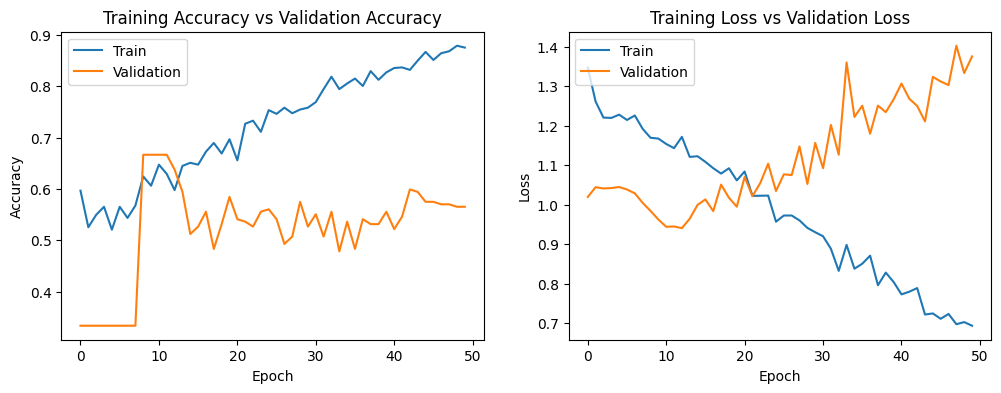

In [25]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')


In [24]:
model = keras.models.load_model('best_model.h5')

In [21]:
model2 = tf.keras.applications.MobileNetV3Small(
    input_shape=(96,96,1),
    alpha=1.0,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling="max",
    classes=2,
    classifier_activation="softmax"
)

In [22]:
model2.compile(optimizer=SGD(learning_rate=0.0001),loss=categorical_crossentropy,metrics=['accuracy'])
history = model2.fit(train_ds, validation_data=val_ds, batch_size=64, epochs=50,callbacks=[es,mc])

Epoch 1/50


52/52 [==============================] - 12s 158ms/step - loss: 0.6927 - accuracy: 0.5543 - val_loss: 0.6926 - val_accuracy: 0.6667
Epoch 2/50
52/52 [==============================] - 7s 131ms/step - loss: 0.6820 - accuracy: 0.6063 - val_loss: 0.6921 - val_accuracy: 0.6667
Epoch 3/50
52/52 [==============================] - 7s 125ms/step - loss: 0.6804 - accuracy: 0.5954 - val_loss: 0.6915 - val_accuracy: 0.6667
Epoch 4/50
52/52 [==============================] - 7s 125ms/step - loss: 0.6790 - accuracy: 0.5978 - val_loss: 0.6910 - val_accuracy: 0.6667
Epoch 5/50
52/52 [==============================] - 7s 126ms/step - loss: 0.6730 - accuracy: 0.6111 - val_loss: 0.6905 - val_accuracy: 0.6667
Epoch 6/50
52/52 [==============================] - 7s 130ms/step - loss: 0.6724 - accuracy: 0.6159 - val_loss: 0.6899 - val_accuracy: 0.6667
Epoch 7/50
52/52 [==============================] - 7s 134ms/step - loss: 0.6686 - accuracy: 0.6341 - val_loss: 0.6894 - val_accuracy: 0.6667
Epoch 8/50
52/52